# Data Exploration

The purpose of this notebook is to explore the dataset we work with. this is supposed to answer two questions:
* What format is our data in?
* Which properties are important for data preparation and machine learning?

Throughout this notebook, we will download our data, inspect it's downloaded form and look into the dataset and associated images to identify any issues we need to deal with.

First, import relevant libraries.
Note that we need to do a small correction here: We want our working directory to be the main directory of this project. Per default, notebooks use their own location as the working directory. We'll need to correct that to point to the parent directory.

In [1]:
# correct working directory only once 
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data.dataset import Dataset

/Users/ninovationlab/Projects/AI/05-Teaching-Materials/01-ML-Example-Project


## Download and Inspect Data

Here we download our data and observe it.

The main interaction with the file system and the kaggle API is done by the *Dataset* class. We can use it to seamlessly download and load files. 

The dataset consists of two parts, a set of pokemon images and a tabular dataset referring to those images. First off, let's look at the dataset.

In [2]:
# Dataset wrapper automatically downloads data the first time we request it.
dataset = Dataset()
data = dataset.get_original_data()

print("Total Pokémon:",len(data))

data.head()

Total Pokémon: 809


,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


As we can see in the previous cell, our dataset has 809 pokemon. For each pokemon we have the following three features:
*  **Name**: the name of the pokemon
* **Type1**: the type of the pokemon
* **Type2**: the second type of the pokemon. This is only set for some second types

In addition, we have an image for each pokemon. The association to the image is done based on the attribute Name.

Let's look at a few images next. you can rerun the cell to see some other images.

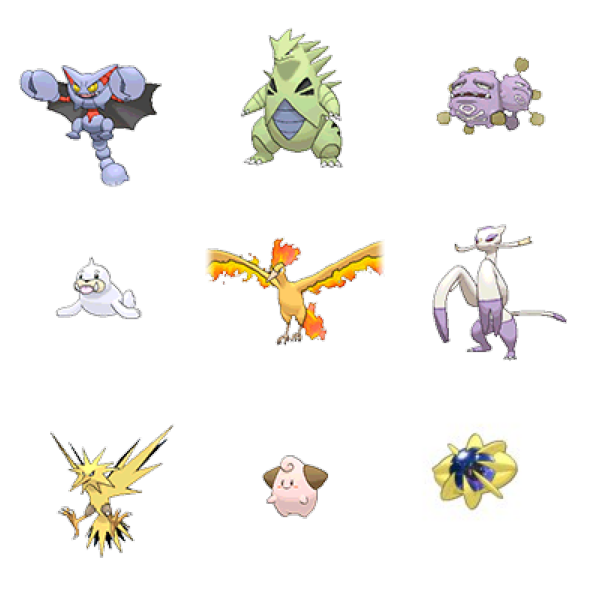

In [3]:
samples = data.sample(n=9)

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(3*2, 3*2))
for index in range(len(samples)):
    image = dataset.get_image(pokemon_name=samples.iloc[index]["Name"])
    axes[index//3][index%3].imshow(X=image) # type: ignore
    axes[index//3][index%3].axis('off')

plt.tight_layout()

## Image Data Properties

Here, we look more closely at the structure of our image data. 

By manual expection of our image data we can identify:
* Our images all have the same size.
* Our images come in two formats: .png and .jpg.  

Having different data formats means, we may have to do some adjustments to get both into the same format. To identify needed adjustments more clearly, let's load "pikachu.png" and "pikipek.jpg" to see if any adjustments will be necessary.

In [4]:
# Looking at Pikachu Data
pikachu_image = dataset.get_image(pokemon_name="pikachu")
pikachu_data = np.array(object=pikachu_image)

pikachu_data.shape

(120, 120, 4)

In [5]:
# Looking at Pikipek Data
pikipek_image = dataset.get_image(pokemon_name="pikipek")
pikipek_data = np.array(object=pikipek_image)
pikipek_data.shape

(120, 120, 3)

As we can see above, our image data indeed has slightly different structures. All images have a size of 120 x 120. The difference in number of color channels can be explained by the iage format. Jpg images have three channels: red, green and blue. Png images have an additional alpha channel for transparency. 

Looking at our images, we can see that these channels are indeed used for the background of the image. Png images have transparent background while jpg images have a white background. This is another thing we will need to fix during data preparation. 

Summarizing, this leads us to to identify the following two images to be fixed:
1) png and jpg images have different numbers of color channels.
2) png and jpg images have different background colors

## Tabular Data Properties

Here we look more closely at our dataset. Our dataset contains only three string features, so the only data validation we need to do is checking for missing values. We do this for all three features below. 

In [6]:
print("Missing names:", data["Name"].isna().sum())
print("Missing Type1:", data["Type1"].isna().sum())
print("Missing Type2:", data["Type2"].isna().sum())

Missing names: 0
Missing Type1: 0
Missing Type2: 404


This looks pretty good already. No names or primary types are missing. There seem to be quite a lot of missing secondary types, but that is to be expected since not all pokemon have two types. This means, our data doesn't have faulty entries (that we can see). We don't have to change anything here, though we should make sure to remember that Type2 is only set for some Pokemon.

Another concern with this dataset is its balancedness. We should check which pokemon class is represented how often to check if our labels are balanced or skewed. 

Let's plot some information related to this.

Number of classes: 18
Number of Samples: 1214
Average samples per class: 67.44444444444444
Minority class: Ice : 34
Majority class: Water : 131


<AxesSubplot: xlabel='Types', ylabel='Counts'>

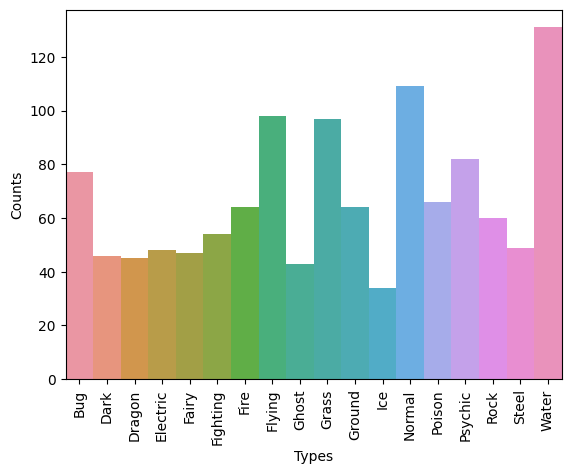

In [7]:
label_counts = {}

# Column Type1
labels, counts = np.unique(ar=data["Type1"], return_counts=True)

for index in range(len(labels)):
    label_counts[labels[index]] = counts[index]

# Column Type2
labels, counts = np.unique(
    ar=data[data["Type2"].notnull()]["Type2"], 
    return_counts=True
)
for index in range(len(labels)):
    if labels[index] in label_counts.keys():
        label_counts[labels[index]] += counts[index]
    else:
        label_counts[labels[index]] = counts[index]

plt.xlabel("Types")
plt.ylabel("Counts")
plt.xticks(rotation=90)

keys = list(label_counts.keys())
values = [label_counts[key] for key in keys]

# General statistics
print("Number of classes:", len(values))
print("Number of Samples:", sum(values))
print("Average samples per class:",sum(values)/len(values), end="\n")

# Minimum and maximum class
min_class = min(label_counts, key=label_counts.get)  # type: ignore
max_class = max(label_counts, key=label_counts.get)  # type: ignore

print("Minority class:", min_class, ":", label_counts[min_class])
print("Majority class:", max_class, ":", label_counts[max_class])

# Plot the distribution
sns.barplot(x=keys, y=values, width=1)


In the barplot we can identify that our dataset is slightly unbalanced. The majority class is "water" with 131 samples and the minority class is "ice" with 34 samples. While this is not perfect, it is also not extremeply bad. Our majority class has about twice as many samples as the average class, while the minority class has about half as many as the average class. While we should keep this unbalanced nature in mind, the dataset is still usable for machine learning.

One thing to note in particular, is that a machine learning classifier that always guesses Water would be expected to achieve an accuracy of around 11% (131/1214). This is a good benchmark to test our machine learning models against. 

## Summary

In summary, let's answer our two questions:

### Which format is our data in?
Our dataset consists of 809 pokemon and for each records the name and up to two pokemon types. Columns Type1 and Type2 belong together. They model a relationship where a pokemon can have either one or two types.
For each pokemon we have one image with dimensions 120x120.

### Which properties are important for data preparation and machine learning?
We identified the following images that need to be taken into account:
1) Images have different numbers of color channels based on their formats (png has 4 and jpg has 3)
2) Images have different background colors based on their formats (png has transparent background and jpg has white background)
3) Column Type2 contains quite a lot of missing values because not all pokemon have two types.  
4) The dataset is somewhat unbalanced, but not extremely so. A majority-class classifier would achieve around 11% accuracy.